## Imports and Cleaning

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import r2_score

from data_clean import *
from model_helper import *
%load_ext autoreload
%autoreload 2

In [3]:
# Read in live data (countries from Johns Hopkins, states + count)
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

testing = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')

In [4]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

df_testing = clean_data_trackingproject(testing)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_testing.loc[df_testing.State.isin(['NY'])].tail()

,State,Date,Positive,Negative,Pending,HospitalizedCurrently,HospitalizedCumulative,InIcuCurrently,InIcuCumulative,OnVentilatorCurrently,OnVentilatorCumulative,Recovered,Death,Hospitalized,Total,TotalTestResults,PosNeg,DeathIncrease,HospitalizedIncrease,NegativeIncrease,PositiveIncrease,TotalTestResultsIncrease
1158,NY,2020-04-01,83712.0,137168.0,NaN,12226.0,18368.0,3022.0,3022.0,NaN,NaN,6142.0,1941.0,18368.0,220880,220880,220880,391.0,2464.0,7777.0,7917.0,15694.0
1159,NY,2020-04-02,92381.0,146584.0,NaN,13383.0,20817.0,3396.0,NaN,NaN,NaN,7434.0,2373.0,20817.0,238965,238965,238965,432.0,2449.0,9416.0,8669.0,18085.0
1160,NY,2020-04-03,102863.0,157657.0,NaN,14810.0,23696.0,3731.0,NaN,NaN,NaN,8886.0,2935.0,23696.0,260520,260520,260520,562.0,2879.0,11073.0,10482.0,21555.0
1161,NY,2020-04-04,113704.0,169917.0,NaN,15905.0,26383.0,4126.0,NaN,NaN,NaN,10478.0,3565.0,26383.0,283621,283621,283621,630.0,2687.0,12260.0,10841.0,23101.0
1162,NY,2020-04-05,122031.0,180249.0,NaN,16479.0,28092.0,4376.0,NaN,NaN,NaN,12187.0,4159.0,28092.0,302280,302280,302280,594.0,1709.0,10332.0,8327.0,18659.0


In [6]:
df_state.loc[df_state.State == 'New York'].tail()

,State,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
1137,New York,2020-03-31,75832,2020-03-01,31,8658.0,3.433987,11.236276,9.066239
1138,New York,2020-04-01,83889,2020-03-01,32,8057.0,3.465736,11.337250,8.994297
1139,New York,2020-04-02,92770,2020-03-01,33,8881.0,3.496508,11.437879,9.091669
1140,New York,2020-04-03,102870,2020-03-01,34,10100.0,3.526361,11.541221,9.220291
1141,New York,2020-04-04,114996,2020-03-01,35,12126.0,3.555348,11.652653,9.403107


In [ ]:
## 

### Regression of actual cases using weighted local regression

In [8]:
x = df_country.loc[df_country.Country=='US'].DaysElapsed.values
y = df_country.loc[df_country.Country=='US'].Confirmed.values

In [9]:
lowess = regress(x, y, how='lowess')

d = 3
x_range, y_hat = predict(x, lowess[1], days=d, extend=False)

preds = pd.DataFrame(list(zip(x_range, np.around(y_hat,2))), columns =['DaysElapsed', 'ConfirmedPred']) 
preds

R2 for lowess: 0.99991


,DaysElapsed,ConfirmedPred
0,76,369091.75
1,77,400177.83
2,78,431263.90


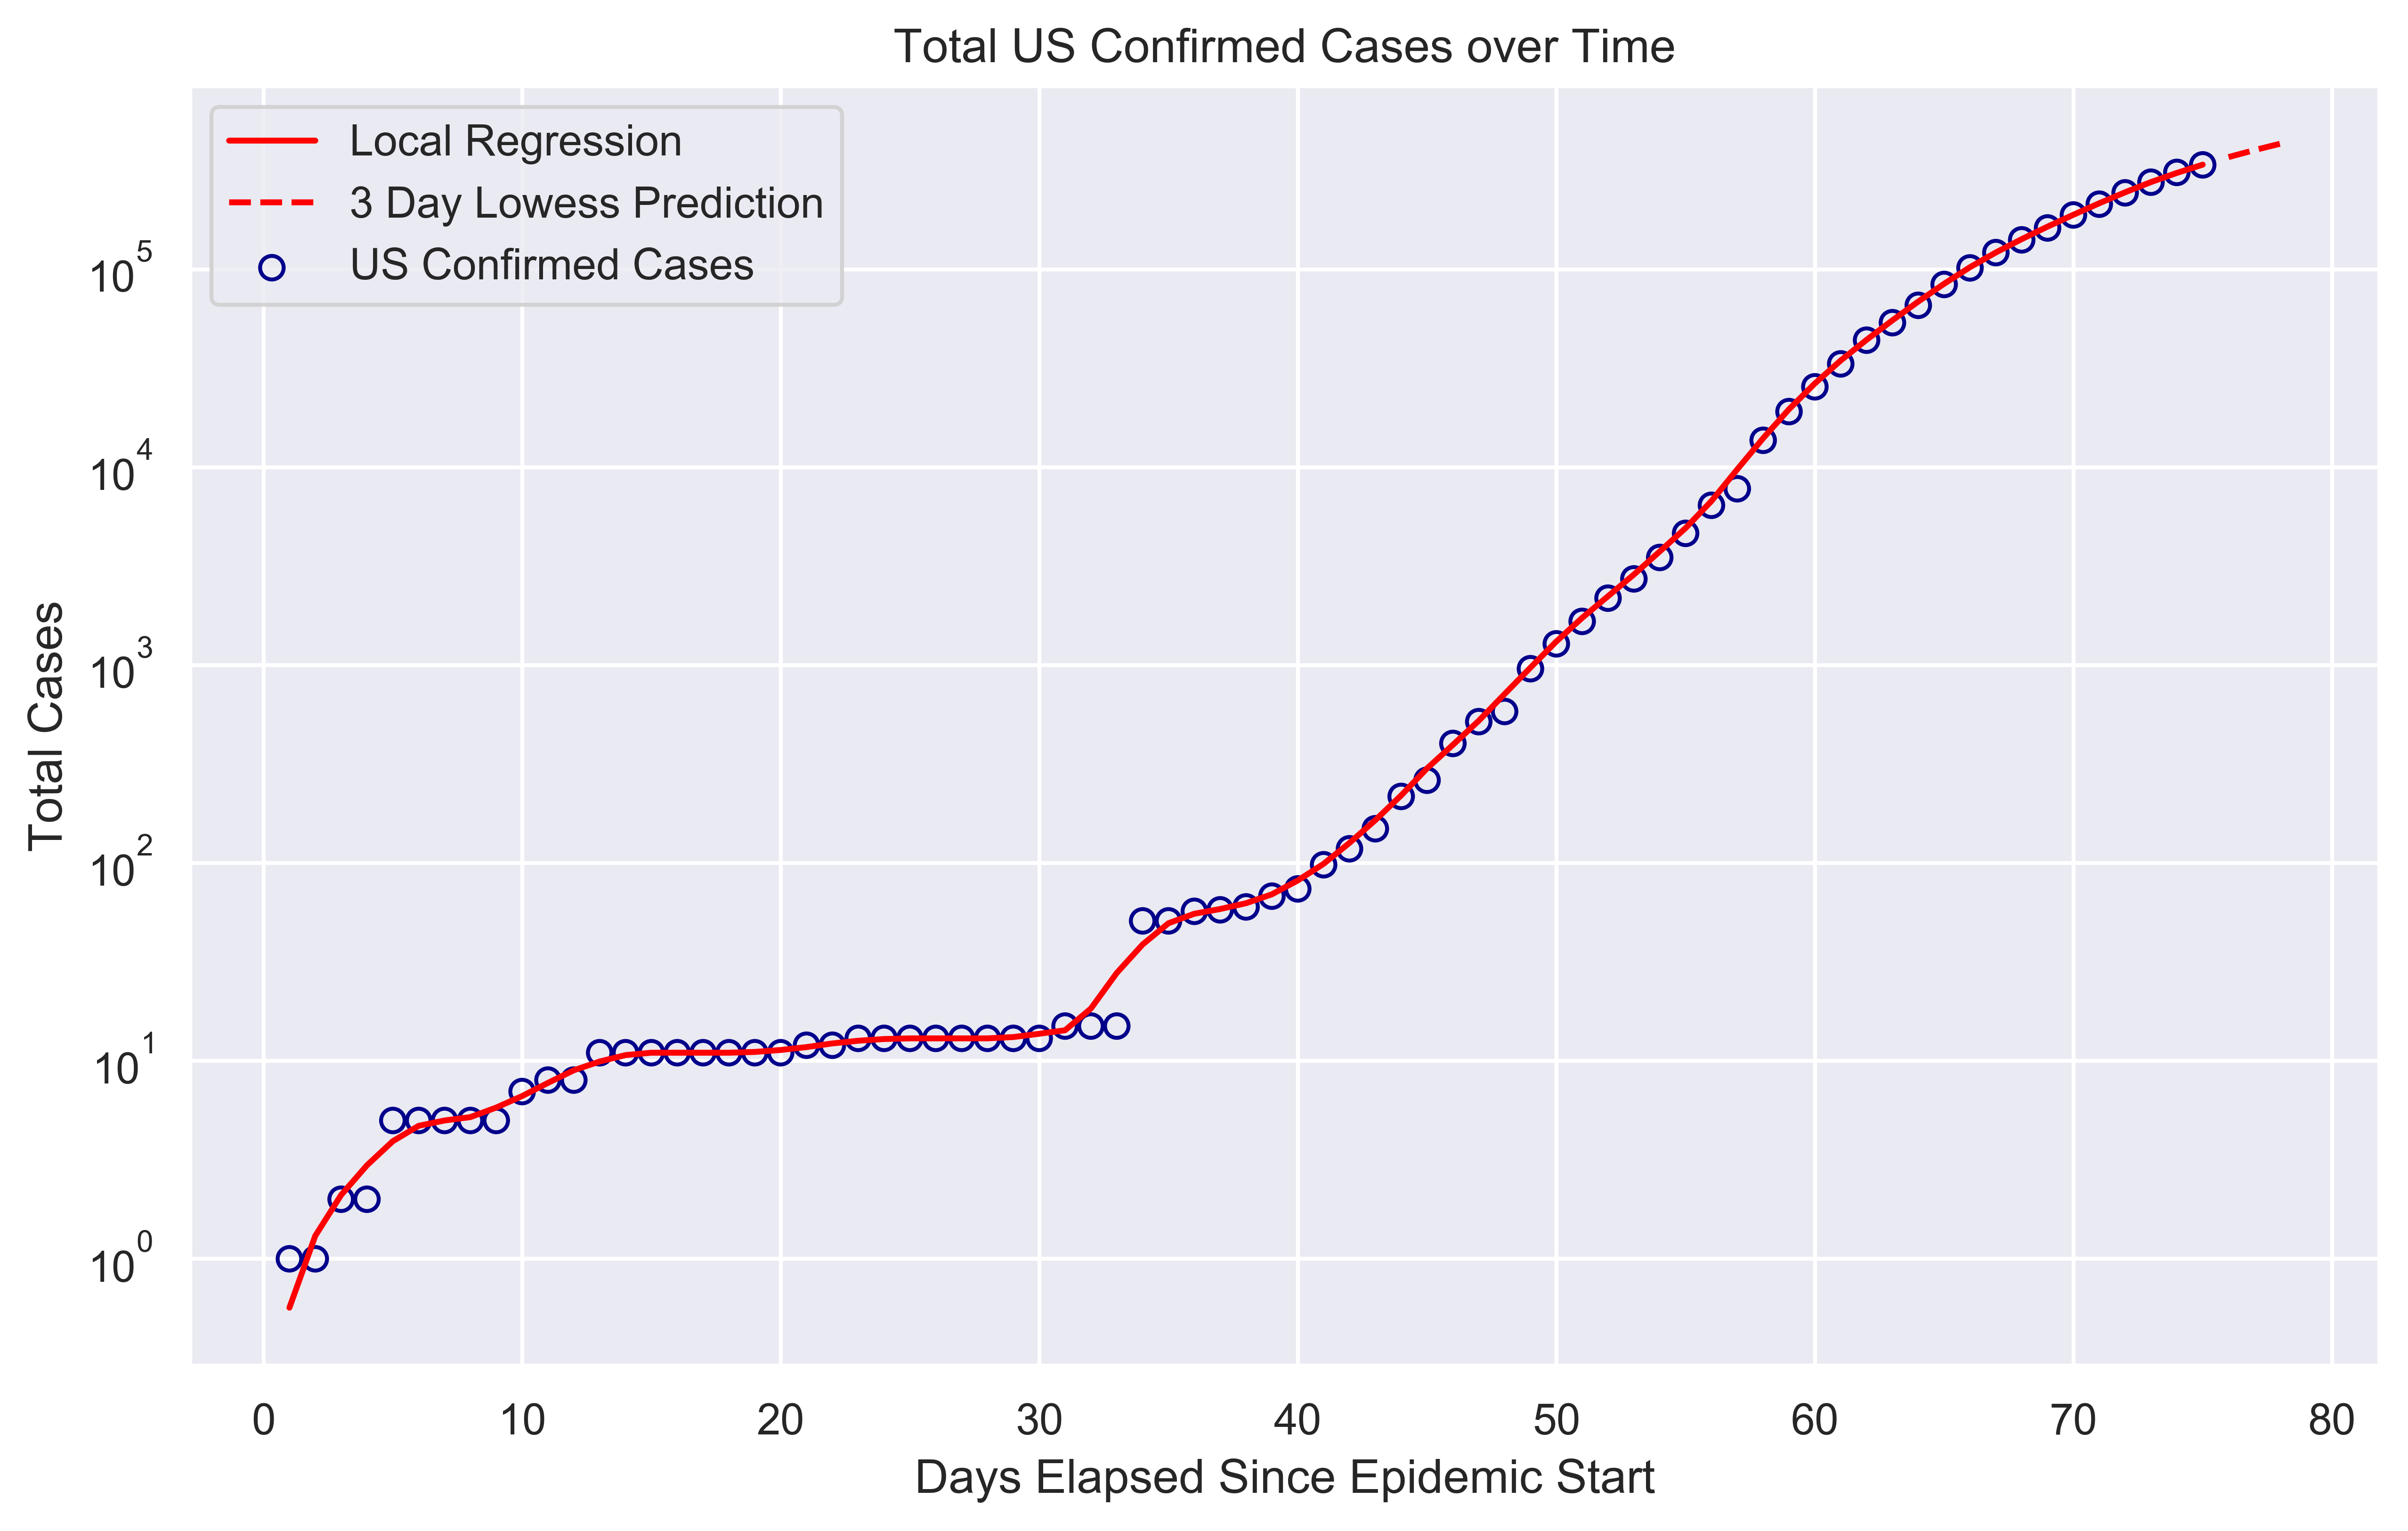

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, lowess[1], color = 'red', label = 'Local Regression')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')

plt.plot(x_range, y_hat, '--', color = 'red', label = '{} Day Lowess Prediction'.format(d))
# plt.plot(x_extended, y_hat_exp, color = 'orange', label = 'exp')

plt.yscale('log')

plt.legend()
plt.ylabel('Total Cases')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Total US Confirmed Cases over Time')
plt.show()

### Regression of cases using compounded growth

In [11]:
df_country.loc[df_country.Country == 'US'].tail()

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
12980,US,2020-04-01,213372,2020-01-22,71,25200.0,4.262680,12.270792,10.134599
13163,US,2020-04-02,243453,2020-01-22,72,30081.0,4.276666,12.402679,10.311649
13346,US,2020-04-03,275586,2020-01-22,73,32133.0,4.290459,12.526655,10.377639
13529,US,2020-04-04,308850,2020-01-22,74,33264.0,4.304065,12.640611,10.412231
13712,US,2020-04-05,337072,2020-01-22,75,28222.0,4.317488,12.728052,10.247857


In [12]:
US = df_country.loc[df_country.Country == 'US']
y = US.Confirmed_Log.diff(periods=1).values 
x = US.DaysElapsed.values

In [13]:
params = np.polyfit(x[1:], y[1:], deg=1)
y_hat = np.exp(params[0]) * np.exp(params[1]*x)

In [14]:
y_hat - y

array([           nan, 1.23418974e+00, 6.76760228e-01, 1.52054927e+00,
       7.71465727e-01, 1.87335059e+00, 2.07935357e+00, 2.30800967e+00,
       2.56180994e+00, 2.50704712e+00, 3.02267555e+00, 3.50327922e+00,
       3.57006357e+00, 4.31611808e+00, 4.79073997e+00, 5.31755367e+00,
       5.90229842e+00, 6.55134463e+00, 7.27176320e+00, 8.07140259e+00,
       8.87196295e+00, 9.94414788e+00, 1.09576133e+01, 1.22514118e+01,
       1.35986382e+01, 1.50940124e+01, 1.67538254e+01, 1.85961597e+01,
       2.06410863e+01, 2.29108832e+01, 2.52871775e+01, 2.82267187e+01,
       3.13306696e+01, 3.35521711e+01, 3.86000832e+01, 4.27335155e+01,
       4.75387711e+01, 5.27517744e+01, 5.84650893e+01, 6.49485718e+01,
       7.19035945e+01, 7.99365475e+01, 8.86996472e+01, 9.83364646e+01,
       1.09378879e+02, 1.21187789e+02, 1.34735864e+02, 1.49715283e+02,
       1.65812230e+02, 1.84308699e+02, 2.04636563e+02, 2.27158859e+02,
       2.52214006e+02, 2.79948447e+02, 3.10729152e+02, 3.44883254e+02,
      

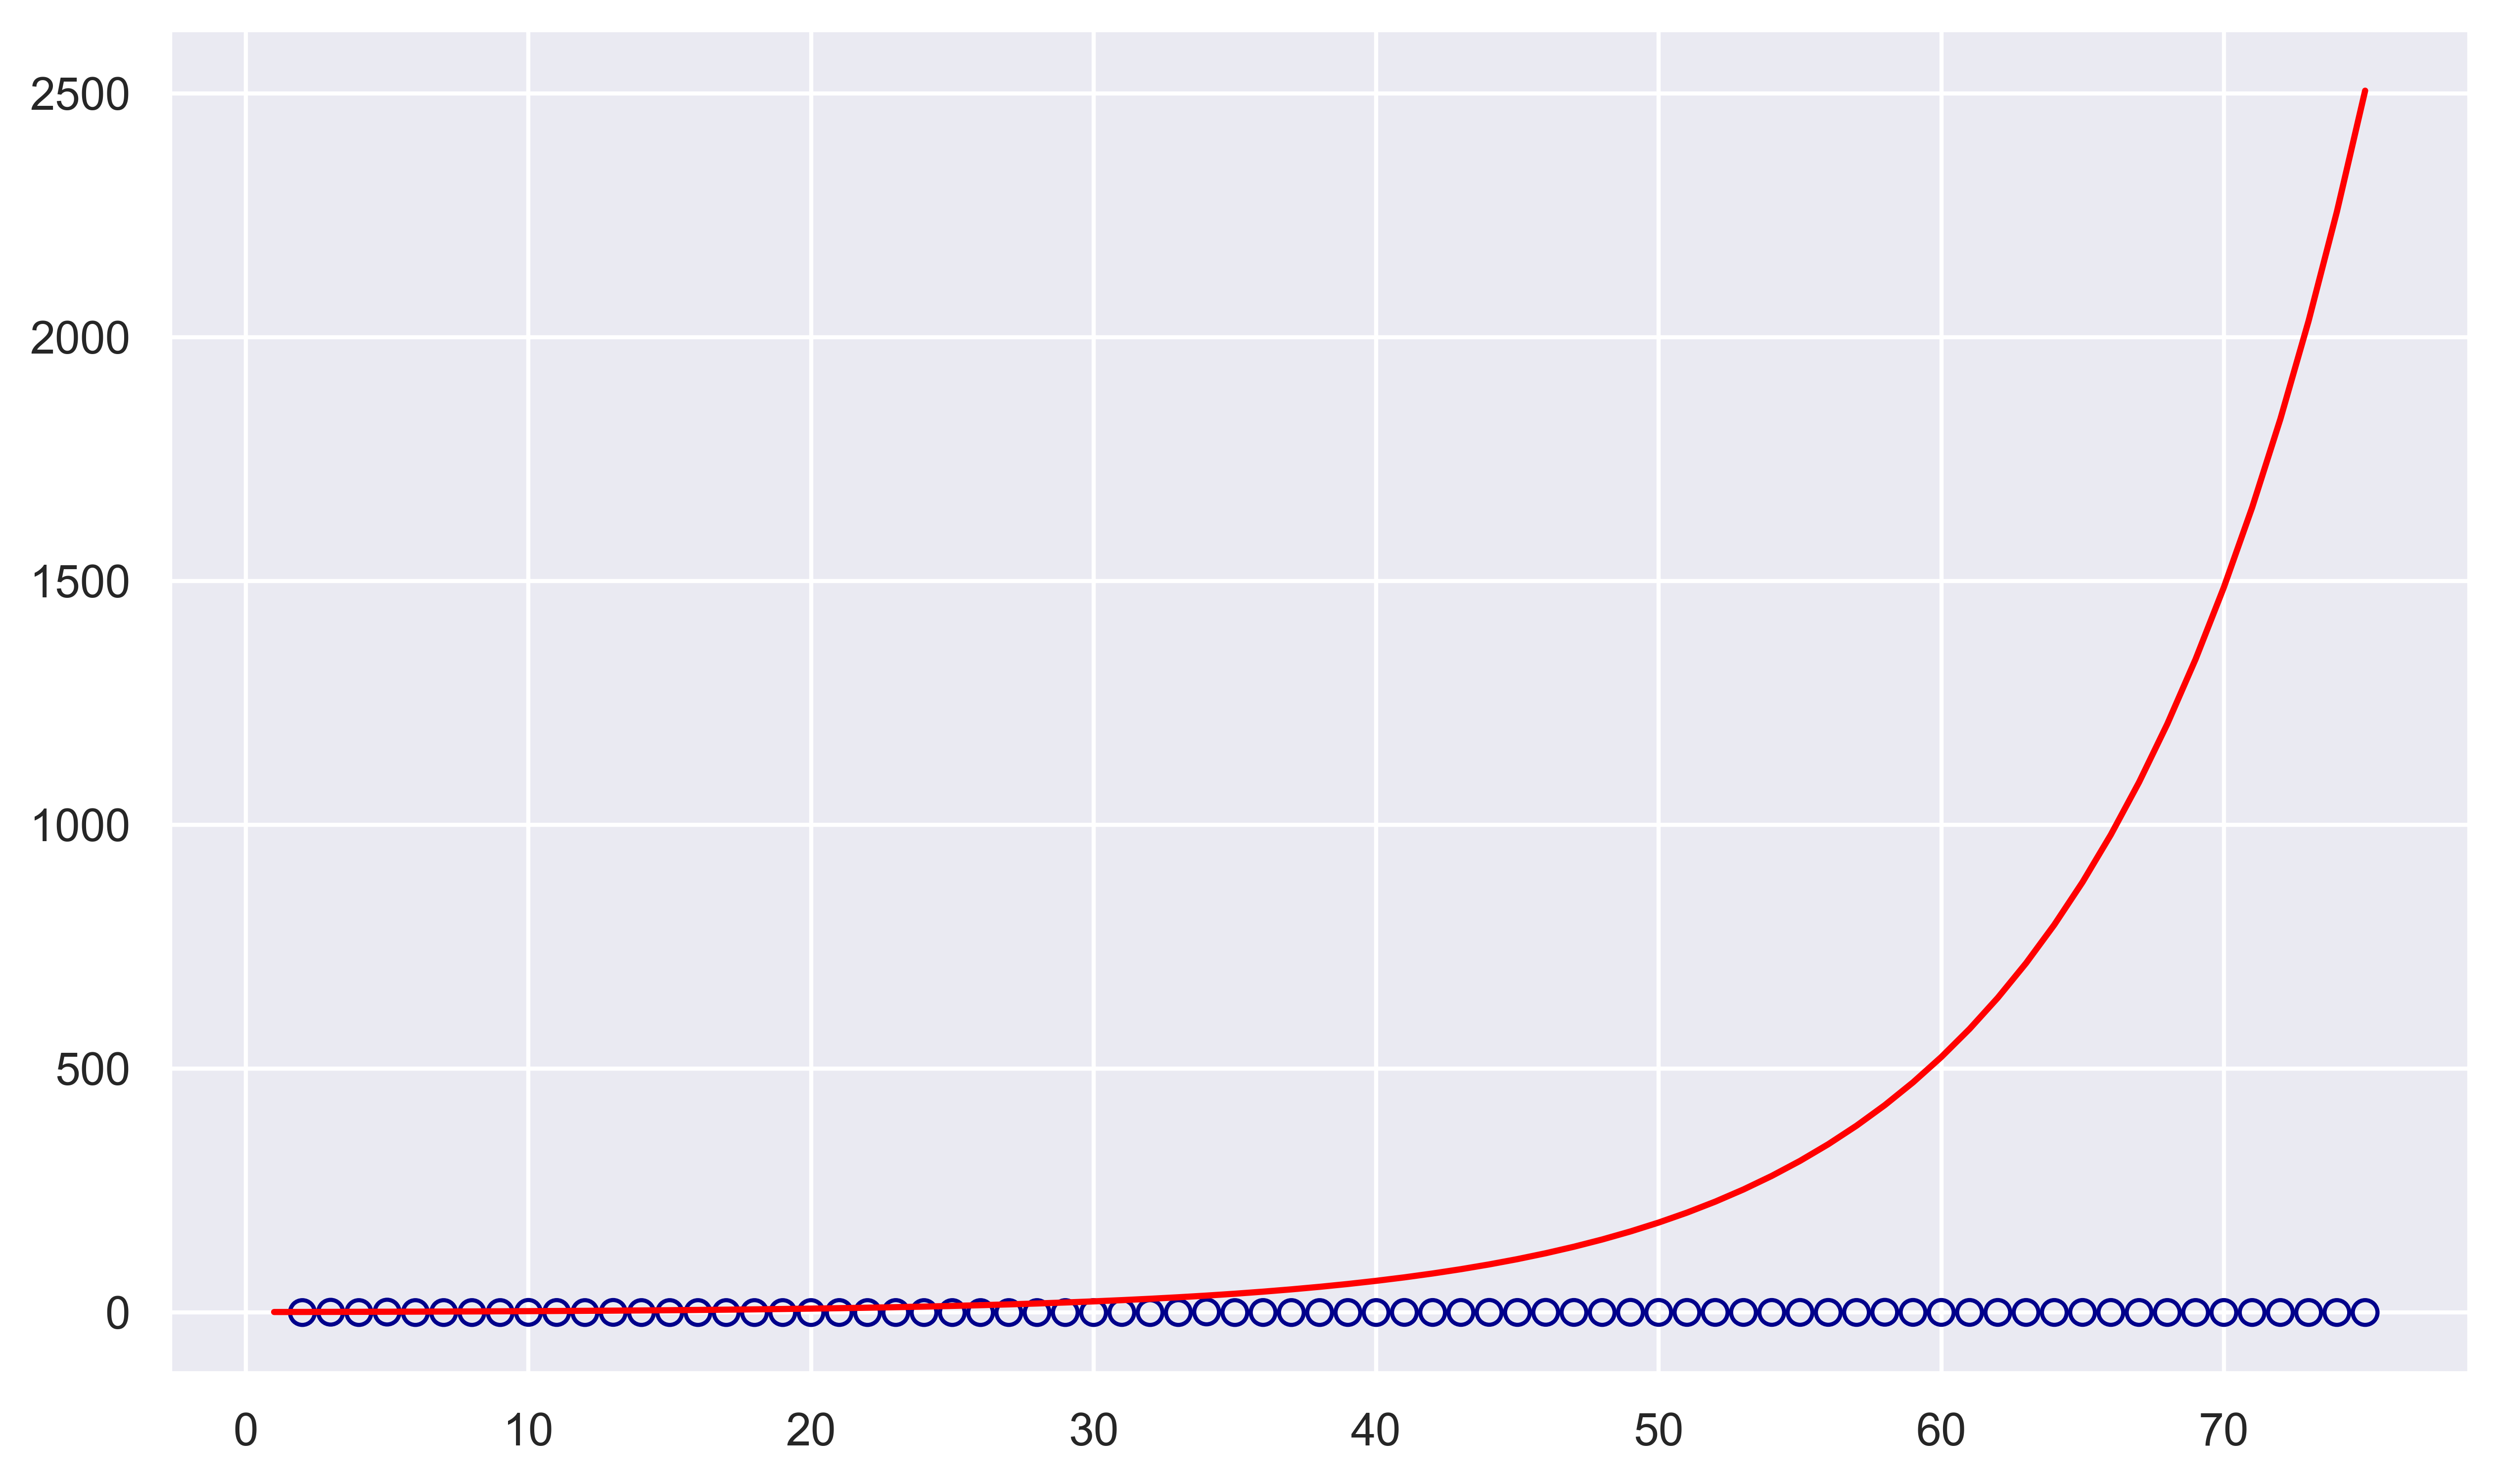

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, y_hat, color = 'red', label = 'Local Regression')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')a

# plt.plot(x, y_hat, '--', color = 'red', label = '{} Day Lowess Prediction'.format(d))
plt.show()